<a href="https://colab.research.google.com/github/katarinagresova/DeepFRI/blob/master/Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The goal of this notebook is to use DeepFRI ([Gligorijević, Vladimir, et al., 2021](http://dx.doi.org/10.1038/s41467-021-23303-9)) for generating structural embedding of protein.

**Input:** protein structure in `.pdb` format  
**Output:** embedding vector with 1024 features

# Setup

In [1]:
#!git clone https://github.com/flatironinstitute/DeepFRI.git
%cd DeepFRI

/protein-db/alphafold-protein-pipeline/DeepFRI


Found existing installation: keras 2.13.1
Uninstalling keras-2.13.1:
ERROR: Exception:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/shutil.py", line 816, in move
    os.rename(src, real_dst)
PermissionError: [Errno 13] Permission denied: '/opt/conda/lib/python3.10/site-packages/keras-2.13.1.dist-info/' -> '/tmp/pip-uninstall-aekxilge'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/cli/base_command.py", line 180, in exc_logging_wrapper
    status = run_func(*args)
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/commands/uninstall.py", line 105, in run
    uninstall_pathset = req.uninstall(
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/req/req_install.py", line 687, in uninstall
    uninstalled_pathset.remove(auto_confirm, verbose)
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/req/req_uninstall.py", l

In [2]:
!wget https://users.flatironinstitute.org/~renfrew/DeepFRI_data/trained_models.tar.gz

--2023-09-16 15:17:37--  https://users.flatironinstitute.org/~renfrew/DeepFRI_data/trained_models.tar.gz
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.48
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 903786708 (862M) [application/octet-stream]
Saving to: ‘trained_models.tar.gz’

trained_models.tar. 100%[===================>] 861.92M  31.2MB/s    in 28s     

2023-09-16 15:18:06 (30.3 MB/s) - ‘trained_models.tar.gz’ saved [903786708/903786708]



In [3]:
!tar xvzf trained_models.tar.gz -C .

trained_models/
trained_models/DeepFRI-MERGED_MultiGraphConv_3x512_fcd_1024_ca_10A_enzyme_commission_model_params.json
trained_models/DeepCNN-MERGED_molecular_function.hdf5
trained_models/DeepCNN-MERGED_cellular_component.hdf5
trained_models/lstm_lm.hdf5
trained_models/model_config.json
trained_models/DeepCNN-MERGED_enzyme_commission_model_params.json
trained_models/DeepFRI-MERGED_MultiGraphConv_3x512_fcd_1024_ca_10A_cellular_component.hdf5
trained_models/DeepFRI-MERGED_MultiGraphConv_3x512_fcd_1024_ca_10A_molecular_function_model_params.json
trained_models/DeepCNN-MERGED_cellular_component_model_params.json
trained_models/DeepFRI-MERGED_MultiGraphConv_3x512_fcd_1024_ca_10A_enzyme_commission.hdf5
trained_models/DeepCNN-MERGED_biological_process_model_params.json
trained_models/DeepCNN-MERGED_enzyme_commission.hdf5
trained_models/DeepFRI-MERGED_MultiGraphConv_3x512_fcd_2048_ca_10A_biological_process.hdf5
trained_models/DeepFRI-MERGED_MultiGraphConv_3x512_fcd_1024_ca_10A_molecular_functi

# Prepare data

In [7]:
from deepfrier.utils import seq2onehot
import numpy as np
from Bio.PDB.MMCIFParser import MMCIFParser
from Bio import SeqIO

parser = MMCIFParser()

def load_predicted_PDB(ciffile):
    # Generate (diagonalized) C_alpha distance matrix from a cif file
    structure = parser.get_structure(ciffile.split('/')[-1].split('.')[0], ciffile)
    residues = [r for r in structure.get_residues()]

    # sequence from atom lines
    records = SeqIO.parse(ciffile, 'cif-atom')
    seqs = [str(r.seq) for r in records]

    distances = np.empty((len(residues), len(residues)))
    for x in range(len(residues)):
        for y in range(len(residues)):
            one = residues[x]["CA"].get_coord()
            two = residues[y]["CA"].get_coord()
            distances[x, y] = np.linalg.norm(one-two)

    return distances, seqs[0]

In [8]:
filename = "./examples/pdb_files/A0A023H2U8.cif"
cmap_thresh=10.0

D, seq = load_predicted_PDB(filename)
A = np.double(D < cmap_thresh)

S = seq2onehot(seq)
S = S.reshape(1, *S.shape)
A = A.reshape(1, *A.shape)

/opt/conda/lib/python3.10/site-packages/Bio/SeqIO/PdbIO.py:522: BiopythonParserWarning: Could not determine the PDB ID.
  warnings.warn("Could not determine the PDB ID.", BiopythonParserWarning)


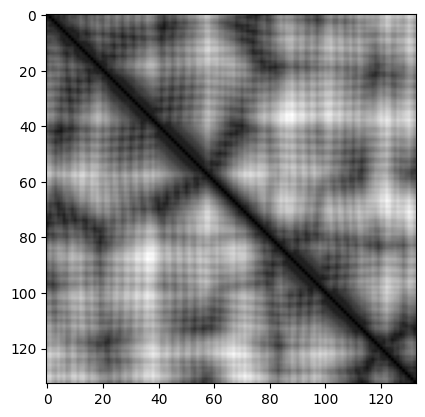

In [9]:
import matplotlib.pyplot as plt

plt.imshow(D)
plt.gray()
plt.show()

# Prepare model

In [11]:
import tensorflow as tf
from deepfrier.layers import MultiGraphConv, GraphConv, FuncPredictor, SumPooling

model = tf.keras.models.load_model("./trained_models/DeepFRI-MERGED_MultiGraphConv_3x512_fcd_1024_ca_10A_molecular_function.hdf5",
                                                custom_objects={'MultiGraphConv': MultiGraphConv,
                                                                'GraphConv': GraphConv,
                                                                'FuncPredictor': FuncPredictor,
                                                                'SumPooling': SumPooling})

In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 seq (InputLayer)            [(None, None, 26)]           0         []                            
                                                                                                  
 model (Functional)          (None, None, 1024)           3207168   ['seq[0][0]']                 
                                                                                                  
 LM_embedding (Dense)        (None, None, 1024)           1049600   ['model[0][0]']               
                                                                                                  
 AA_embedding (Dense)        (None, None, 1024)           26624     ['seq[0][0]']                 
                                                                                            

In [13]:
model.layers[-2]

In [14]:
from keras.models import Model

encoder = Model(model.input, model.layers[-2].output)

# Compute embeddings

In [16]:
encoder.predict([A, S], verbose=1)

InvalidArgumentError: No OpKernel was registered to support Op 'CudnnRNNV2' used by {{node model/model/LSTM1/CudnnRNNV2}} with these attrs: [dropout=0, rnn_mode="lstm", seed2=0, is_training=true, T=DT_FLOAT, input_mode="linear_input", direction="unidirectional", seed=0]
Registered devices: [CPU]
Registered kernels:
  device='GPU'; T in [DT_DOUBLE]
  device='GPU'; T in [DT_FLOAT]
  device='GPU'; T in [DT_BFLOAT16]
  device='GPU'; T in [DT_HALF]

	 [[model/model/LSTM1/CudnnRNNV2]] [Op:__inference_predict_function_3320]

From TF documentation: `For small numbers of inputs that fit in one batch, directly use __call__() for faster execution, e.g., model(x), or model(x, training=False)`.

In [17]:
%timeit encoder([A, S], training=False)

NotFoundError: Exception encountered when calling layer 'LSTM1' (type CuDNNLSTM).

Could not find device for node: {{node CudnnRNNV2}} = CudnnRNNV2[T=DT_FLOAT, direction="unidirectional", dropout=0, input_mode="linear_input", is_training=true, rnn_mode="lstm", seed=0, seed2=0]
All kernels registered for op CudnnRNNV2:
  device='GPU'; T in [DT_DOUBLE]
  device='GPU'; T in [DT_FLOAT]
  device='GPU'; T in [DT_BFLOAT16]
  device='GPU'; T in [DT_HALF]
 [Op:CudnnRNNV2]

Call arguments received by layer 'LSTM1' (type CuDNNLSTM):
  • inputs=tf.Tensor(shape=(1, 133, 26), dtype=float32)
  • mask=None
  • training=False
  • initial_state=None

In [18]:
y = encoder.predict([A, S])

InvalidArgumentError: No OpKernel was registered to support Op 'CudnnRNNV2' used by {{node model/model/LSTM1/CudnnRNNV2}} with these attrs: [direction="unidirectional", is_training=true, rnn_mode="lstm", dropout=0, seed2=0, T=DT_FLOAT, seed=0, input_mode="linear_input"]
Registered devices: [CPU]
Registered kernels:
  device='GPU'; T in [DT_DOUBLE]
  device='GPU'; T in [DT_FLOAT]
  device='GPU'; T in [DT_BFLOAT16]
  device='GPU'; T in [DT_HALF]

	 [[model/model/LSTM1/CudnnRNNV2]] [Op:__inference_predict_function_3320]

In [ ]:
y

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
import pandas as pd

pd.DataFrame(y[0]).describe()

0
count  1024.000000
mean      0.027637
std       0.201912
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       3.394846